## ERA Session7 Assignment: Model0
### Target
 - Setup a skeleton
 - Try to reduce the number of paramters

### Results
 - No. of Params: 75,024
 - Best Test Accuracy: 99.09%
 - Best Train Accuracy: 99.80%

### Analysis
 - Number of parametrs reduced from ~6 million to 75024
 - Accuracy is still maintained at 99+
 - Model architecure is more structured


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from models import Model1 as Model

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                    #    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                    #    transforms.Resize((28, 28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 108212311.77it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 91630630.73it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25901535.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19782480.55it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Model().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
              ReLU-4           [-1, 32, 24, 24]               0
         MaxPool2d-5           [-1, 32, 12, 12]               0
            Conv2d-6           [-1, 32, 10, 10]           9,216
              ReLU-7           [-1, 32, 10, 10]               0
            Conv2d-8           [-1, 64, 10, 10]          18,432
              ReLU-9           [-1, 64, 10, 10]               0
        MaxPool2d-10             [-1, 64, 5, 5]               0
           Conv2d-11             [-1, 64, 3, 3]          36,864
             ReLU-12             [-1, 64, 3, 3]               0
           Conv2d-13             [-1, 10, 1, 1]           5,760
Total params: 75,024
Trainable params: 

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_loss = []
epoch_train_acc = []
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  epoch_train_loss.append(sum(train_losses[-train_loader.batch_size:])/(train_loader.batch_size))
  epoch_train_acc.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
model =  Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.041442882269620895 Batch_id=468 Accuracy=85.73: 100%|██████████| 469/469 [00:19<00:00, 23.54it/s]



Test set: Average loss: 0.0688, Accuracy: 9799/10000 (97.99%)

EPOCH: 2


Loss=0.12111648917198181 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]



Test set: Average loss: 0.0449, Accuracy: 9856/10000 (98.56%)

EPOCH: 3


Loss=0.004981569945812225 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:17<00:00, 26.26it/s]



Test set: Average loss: 0.0331, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.020837223157286644 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 27.42it/s]



Test set: Average loss: 0.0310, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.04517010971903801 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]



Test set: Average loss: 0.0335, Accuracy: 9891/10000 (98.91%)

EPOCH: 6


Loss=0.024565158411860466 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:17<00:00, 26.97it/s]



Test set: Average loss: 0.0335, Accuracy: 9889/10000 (98.89%)

EPOCH: 7


Loss=0.015936287119984627 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:18<00:00, 25.73it/s]



Test set: Average loss: 0.0324, Accuracy: 9897/10000 (98.97%)

EPOCH: 8


Loss=0.007718656677752733 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]



Test set: Average loss: 0.0314, Accuracy: 9902/10000 (99.02%)

EPOCH: 9


Loss=0.003588553750887513 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]



Test set: Average loss: 0.0381, Accuracy: 9882/10000 (98.82%)

EPOCH: 10


Loss=0.0012425901368260384 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]



Test set: Average loss: 0.0304, Accuracy: 9909/10000 (99.09%)

EPOCH: 11


Loss=0.0017699096351861954 Batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:18<00:00, 25.74it/s]



Test set: Average loss: 0.0354, Accuracy: 9895/10000 (98.95%)

EPOCH: 12


Loss=0.0005171220982447267 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s]



Test set: Average loss: 0.0338, Accuracy: 9906/10000 (99.06%)

EPOCH: 13


Loss=0.030472105368971825 Batch_id=468 Accuracy=99.71: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0392, Accuracy: 9902/10000 (99.02%)

EPOCH: 14


Loss=0.0029797053430229425 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]



Test set: Average loss: 0.0448, Accuracy: 9895/10000 (98.95%)

EPOCH: 15


Loss=0.0016831820830702782 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:18<00:00, 25.64it/s]



Test set: Average loss: 0.0386, Accuracy: 9905/10000 (99.05%)



Text(0.5, 1.0, 'Test Accuracy')

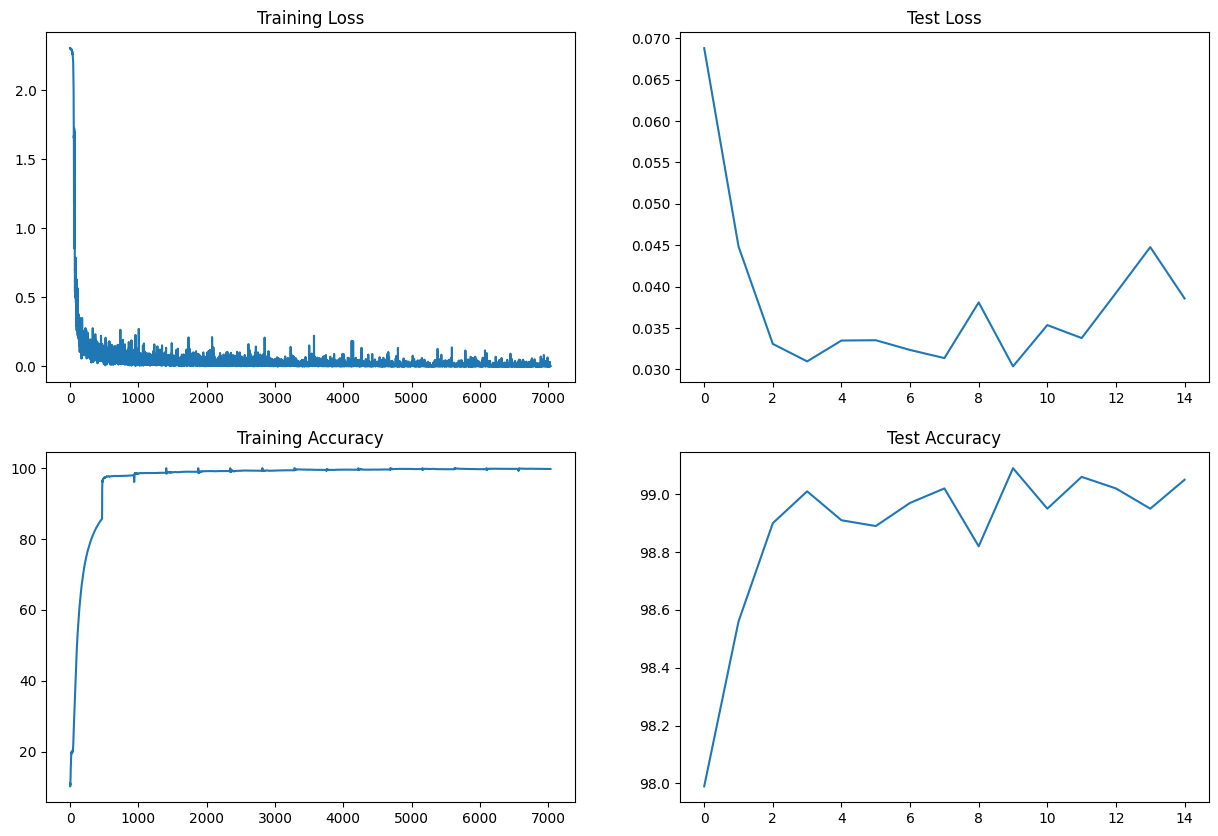

In [9]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")